# Weather Data

> This notebook did not go as planned. The format of [NOAA Integrated Surface Database (ISD)](https://www.ncdc.noaa.gov/isd) data proved too challenging for me to understand. I did find [Jasper Slingsby's](http://www.ecologi.st/post/weather/) blog insightful  but its for ```R``` - if you happen to know how to transform it with ```python``` please let me know.

> I reverted to the recommended [Reliable Prognosis](https://rp5.ru/Weather_in_the_world); where another problem arose.

> Only one weather station, ```cape town airport METAR```, provides hourly data, the other stations have 2-to-3-hour gaps. 

> We are thus presented with a choice: 

1.   select the one, with consistent hourly data, and apply it everywhere;
2.   select the other five and interpolate the data; then create a voronoi diagram, dividing the area into regions and assign each road segment its own weather based on a ```intersects``` and ```within```; ```spatial join```; i.e.: from the weather station closest to it.

> We choose the second. Here [NOAA](https://www.ncdc.noaa.gov/isd) did however prove useful. Its ```isd-history.csv``` supplies wgs84 coordinates for most weather stations. These were harvested and used. A preliminary voronoi was viewed in Colab but polygons were created and some spatial manipulation were conducted with [QGIS](https://www.qgis.org/en/site/). 

> This ```notebook``` is mostly more data wrangling.

In [ ]:
#because we're on google colab
!pip install --upgrade pandas
!pip install --upgrade geopandas
!pip install --upgrade seaborn

In [ ]:
#import the models that make the magic possible
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
from scipy.spatial import Voronoi,voronoi_plot_2d
#import seaborn as sns

In [ ]:
# mount google drive as a file system
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
#set path
path = Path('/content/gdrive/My Drive/Zindi_Accident')

#### Lets look at the [NOAA](https://www.ncdc.noaa.gov/isd) ```isd-history.csv```

In [ ]:
stations = pd.read_csv(path/'data/isd-history.csv',parse_dates=['BEGIN','END'])
# Weather records are queried by a concatenation of USAF and WBAN.
stations['station_id'] = stations.apply(lambda x: str(x['USAF'])+str(x['WBAN']), axis=1)
stations = stations.rename({'STATION NAME':'STATION_NAME'}, axis=1)
stations = stations.set_index('station_id')
stations.head()

,USAF,WBAN,STATION_NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
702699999,7026,99999,WXPOD 7026,AF,NaN,NaN,0.0,0.0,7026.0,2014-07-11,2017-08-22
707099999,7070,99999,WXPOD 7070,AF,NaN,NaN,0.0,0.0,7070.0,2014-09-23,2015-09-26
840399999,8403,99999,XM10,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-01,2014-04-12
841199999,8411,99999,XM20,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-02,2016-02-17
841499999,8414,99999,XM18,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-01,2016-02-17


In [ ]:
cpt_stations = stations.loc[stations['STATION_NAME'].isin(['PAARL', 'STRAND', 'YSTERPLANT(SAAFB)', 'MOLTENO RESERVIOR', 'CAPE TOWN INTL'])]
cpt_stations.head(5)

,USAF,WBAN,STATION_NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
68713099999,687130,99999,PAARL,SF,NaN,NaN,-33.717,18.967,104.0,2004-06-08,2018-01-30
68816099999,688160,99999,CAPE TOWN INTL,SF,NaN,FACT,-33.965,18.602,46.0,1949-01-01,2018-01-30
68819099999,688190,99999,MOLTENO RESERVIOR,SF,NaN,NaN,-33.933,18.417,97.0,2013-12-10,2018-01-30
68827099999,688270,99999,YSTERPLANT(SAAFB),SF,NaN,NaN,-33.900,18.500,16.0,2004-02-24,2018-01-30
68911099999,689110,99999,STRAND,SF,NaN,NaN,-34.150,18.850,10.0,2004-05-25,2018-01-30


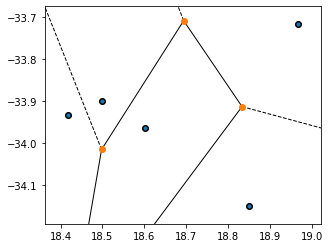

In [ ]:
# Let's have a look at a preliminary voronoi
start = pd.Timestamp(2017,1,1)
end = pd.Timestamp(2018,12,31)
valid_stations = cpt_stations[(cpt_stations.BEGIN < start) & (cpt_stations.END > start)]
plt.figure()

lons = valid_stations.LON.values
lats = valid_stations.LAT.values
plt.plot(lons, lats,'ko')


vor = Voronoi(np.vstack((lons,lats)).T)
voronoi_plot_2d(vor,ax=plt.gca())
plt.gca().set_aspect(1)
plt.show()

In [ ]:
#save it
cpt_stations.to_csv(path/'data/cpt_weather_stns.csv', index = False)

#### Here I took the ```csv``` into QGIS to create proper voronio polygons and conduct a ```intersects``` and ```within```; ```spatial join``` with the SANRAL road segments. This meant every road was associated with its own weather station. The results are below. 

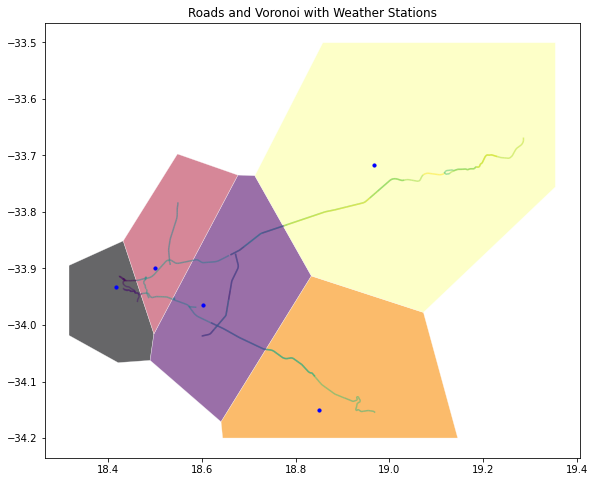

In [ ]:
#load the voronoi and new road_segments
voronoi = gpd.read_file(path/'data/voronoi.shp')
road_voronoi = gpd.read_file(path/'data/roads_voronoi.shp')
#rename a column
road_voronoi = road_voronoi.rename({'STATION NA':'STATION_NA'}, axis=1)

# plot
#the voronoi polygons
ax = voronoi.plot(cmap='inferno', linewidth=0.5, alpha=0.6,edgecolor='white', figsize=(20,8))
#the weather stations
ax.scatter(cpt_stations.LON, cpt_stations.LAT, zorder=1, c='b', s=10)
#the new road_segments
road_voronoi.plot(cmap='viridis', alpha=0.5, ax=ax)
#plt.plot(ax=ax, lons, lats,)
ax.set_title('Roads and Voronoi with Weather Stations')
plt.show()

#### Now lets have a look at the weather from [Reliable Prognosis](https://rp5.ru/Weather_in_the_world). We start with one; ```resample``` and then ```interpolate```. See how it works and then do the other 4.

In [ ]:
#read the cape town airport weather station data
cpt_air = pd.read_csv(path/'data/weather/cpt_air_weather.csv', sep = ';', skiprows=6, usecols=range(29),
                      parse_dates = ['Local time in Cape Town (airport)'])
#rename some columns
cpt_air.rename(columns={'Local time in Cape Town (airport)': 'dt', 'T': 'Air_temp','Po': 'Atmos_press', 'P': 'Atmos_press_MeanSea', 
                        'U': 'Humidity', 'Pa': 'PressureTendency', 'Ff': 'MeanWindSpeed', 'VV': 'Visibility','Td':'DewPoint', 
                        'RRR': 'Rainfall'}, inplace=True)

#delete some columns
cpt_air.drop(['DD', 'ff10', 'ff3', 'N',  'WW','W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 'Ch',
              'tR', 'E', 'Tg', 'E_' ,'sss',], axis=1, inplace=True)

cpt_air.head(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall
0,2018-12-31 23:00:00,20.0,757.3,761.3,1.2,85.0,5.0,40.0,17.3,NaN
1,2018-12-31 20:00:00,26.7,756.1,760.0,0.0,41.0,5.0,55.0,12.2,NaN
2,2018-12-31 17:00:00,26.7,756.1,760.0,0.0,41.0,5.0,55.0,12.2,NaN


In [ ]:
cpt_air.tail(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall
5619,2017-01-01 08:00:00,23.2,755.0,759.0,0.1,65.0,4.0,30.0,16.2,NaN
5620,2017-01-01 05:00:00,20.1,754.9,759.0,-0.8,77.0,4.0,20.0,16.0,NaN
5621,2017-01-01 02:00:00,21.4,755.7,759.7,-1.5,70.0,5.0,30.0,15.7,NaN


#### You can immediatley see the 3-hour gaps. Furthermore when you check the ```NaN``` the data has "*holes*".

In [ ]:
#check NaN
cpt_air.isnull().sum(axis = 0)

dt                        0
Air_temp                  1
Atmos_press               0
Atmos_press_MeanSea       0
PressureTendency        230
Humidity                  2
MeanWindSpeed            17
Visibility                7
DewPoint                  1
Rainfall               5035
dtype: int64

In [ ]:
cpt_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5622 entries, 0 to 5621
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt                   5622 non-null   datetime64[ns]
 1   Air_temp             5621 non-null   float64       
 2   Atmos_press          5622 non-null   float64       
 3   Atmos_press_MeanSea  5622 non-null   float64       
 4   PressureTendency     5392 non-null   float64       
 5   Humidity             5620 non-null   float64       
 6   MeanWindSpeed        5605 non-null   float64       
 7   Visibility           5615 non-null   float64       
 8   DewPoint             5621 non-null   float64       
 9   Rainfall             587 non-null    object        
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 439.3+ KB


In [ ]:
#check some values
cpt_air.Rainfall.unique()

array([nan, '3.0', '1.0', 'Trace of precipitation', '0.6', '2.0', '0.2',
       '7.0', '9.0', '10.0', '5.0', '4.0', '0.4', '6.0', '13.0', '11.0',
       'No precipitation', '0.8', '24.0', '22.0', '19.0', '8.0', '26.0',
       '18.0', '15.0', '16.0', '30.0', '23.0', '34.0', '0.9', '17.0',
       '25.0', '14.0'], dtype=object)

#### Right here you can see why I did not automate this process. Some columns contain unique ```text``` along with ```values```. These need to be transformed  as required.

In [ ]:
#change some text
cpt_air.loc[cpt_air['Rainfall'] ==  'Trace of precipitation', 'Rainfall'] = 0.1
cpt_air.loc[cpt_air['Rainfall'] ==  'No precipitation', 'Rainfall'] = 0

#transform to numeric
cpt_air["Rainfall"] = pd.to_numeric(cpt_air["Rainfall"])

In [ ]:
#set as datetime index
cpt_air = cpt_air.set_index(pd.DatetimeIndex(cpt_air['dt']))

#### ```resample``` to 1-hour periods and ```interpolate``` - we cannot ```interpolate```  over the entire timeperiod because our results would be false. We can however limit the ```interpolation``` to fill one ```NaN```either side of a value; if it exists. 

#### This means; that if values need to be ```interpolated```; they will follow the trend for one-hour but leave other ```NaN``` inplace.

In [ ]:
columns = ['Air_temp', 'Atmos_press', 'Atmos_press_MeanSea', 'PressureTendency', 'Humidity', 'MeanWindSpeed',
           'Visibility', 'DewPoint', 'Rainfall']
           
#resample to every hour
cpt_air_h = cpt_air.resample('H', on='dt').mean()

# linear interpolation in both directions and fill only one consecutive NaN
cpt_air_inter = cpt_air_h[columns].interpolate(limit_direction = 'both', method='linear', limit = 1)

cpt_air_inter.head(4)

,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall
dt,,,,,,,,,
2017-01-01 02:00:00,21.400000,755.700000,759.700000,-1.500000,70.000000,5.000000,30.000000,15.7,NaN
2017-01-01 03:00:00,20.966667,755.433333,759.466667,-1.266667,72.333333,4.666667,26.666667,15.8,NaN
2017-01-01 04:00:00,20.533333,755.166667,759.233333,-1.033333,74.666667,4.333333,23.333333,15.9,NaN
2017-01-01 05:00:00,20.100000,754.900000,759.000000,-0.800000,77.000000,4.000000,20.000000,16.0,NaN


In [ ]:
cpt_air_inter.tail(4)

,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall
dt,,,,,,,,,
2018-12-31 20:00:00,26.700000,756.1,760.000000,0.0,41.000000,5.0,55.0,12.2,NaN
2018-12-31 21:00:00,24.466667,756.5,760.433333,0.4,55.666667,5.0,50.0,13.9,NaN
2018-12-31 22:00:00,22.233333,756.9,760.866667,0.8,70.333333,5.0,45.0,15.6,NaN
2018-12-31 23:00:00,20.000000,757.3,761.300000,1.2,85.000000,5.0,40.0,17.3,NaN


In [ ]:
#check some values
print(cpt_air_inter.Rainfall.unique())

In [ ]:
cpt_air_inter.tail(4)

,Air_temp,Atmos_press,Atmos_press_MeanSea,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall
dt,,,,,,,,
2018-12-31 20:00:00,26.700000,756.1,760.000000,41.000000,5.0,55.0,12.2,NaN
2018-12-31 21:00:00,24.466667,756.5,760.433333,55.666667,5.0,50.0,13.9,NaN
2018-12-31 22:00:00,22.233333,756.9,760.866667,70.333333,5.0,45.0,15.6,NaN
2018-12-31 23:00:00,20.000000,757.3,761.300000,85.000000,5.0,40.0,17.3,NaN


#### Lets create some graphs to understand the data a bit better

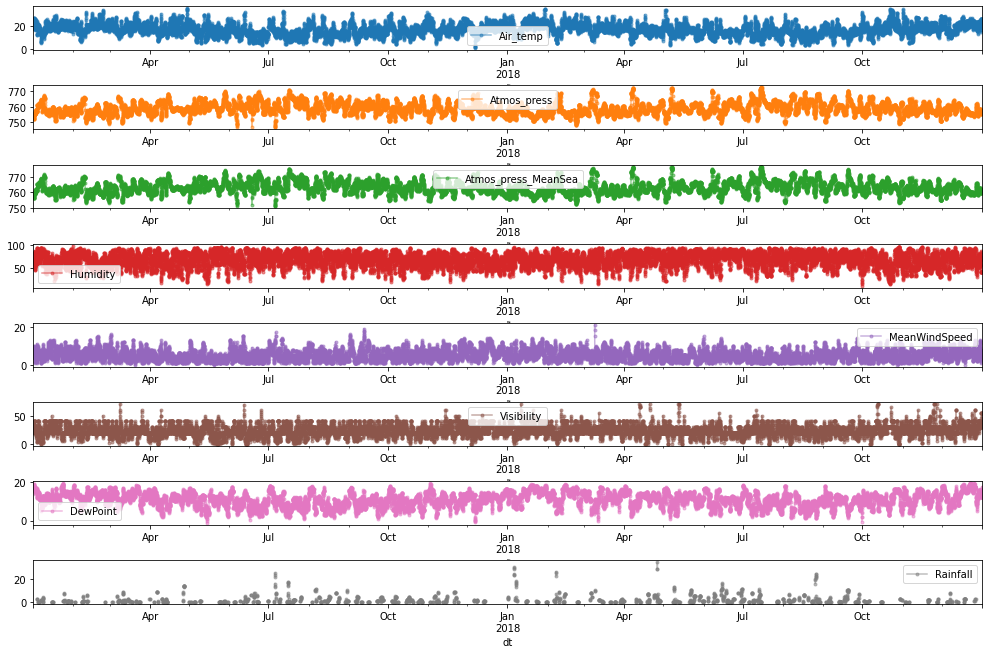

In [ ]:
fig, axes = plt.subplots(ncols = 1, nrows = 8, figsize=(17, 11))

cols_plot = ['Air_temp', 'Atmos_press', 'Atmos_press_MeanSea', 'Humidity', 'MeanWindSpeed', 'Visibility', 
             'DewPoint', 'Rainfall']
cpt_air_inter[cols_plot].plot(ax=axes, marker='.', alpha=0.5, linestyle='-', subplots=True)
plt.subplots_adjust(hspace = 0.8, wspace= 0.3)
plt.show()

#### Its a bit noisy. Lets look at two slices of time, three days in Summer (Feb.) and three in Winter (Jul).

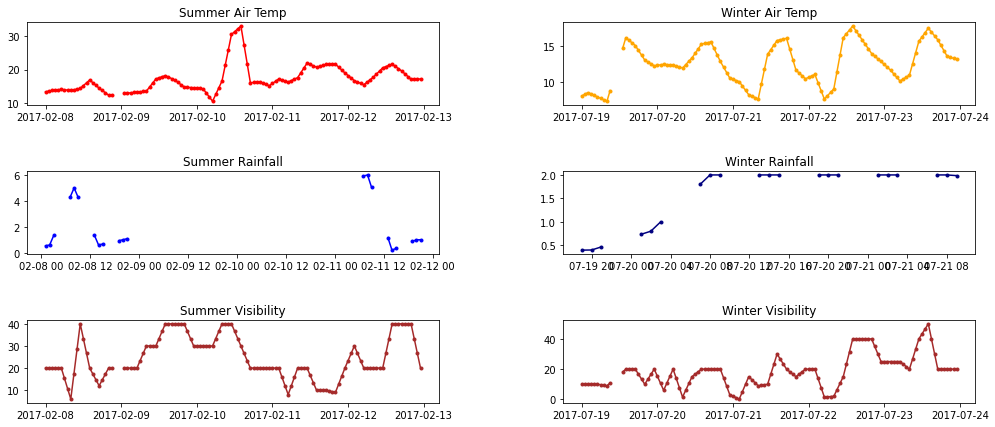

In [ ]:
sum_start, sum_end = '2017-02-08', '2017-02-12'
win_start, win_end = '2017-07-19', '2017-07-23'

# Plot daily and weekly resampled time series together
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(17,7))

ax1.plot(cpt_air_inter.loc[sum_start:sum_end, 'Air_temp'], color= 'red', linestyle='-',marker='.')
ax1.set_title('Summer Air Temp')

ax2.plot(cpt_air_inter.loc[win_start:win_end, 'Air_temp'],marker='.',  color = 'orange')
ax2.set_title('Winter Air Temp')

ax3.plot(cpt_air_inter.loc[sum_start:sum_end, 'Rainfall'], marker='.', linestyle='-', color = 'blue')
ax3.set_title('Summer Rainfall')

ax4.plot(cpt_air_inter.loc[win_start:win_end, 'Rainfall'], marker='.', linestyle='-', color = 'navy')
ax4.set_title('Winter Rainfall')

ax5.plot(cpt_air_inter.loc[sum_start:sum_end, 'Visibility'], marker='.', linestyle='-', color = 'brown')
ax5.set_title('Summer Visibility')

ax6.plot(cpt_air_inter.loc[win_start:win_end, 'Visibility'], marker='.', linestyle='-', color = 'brown')
ax6.set_title('Winter Visibility')

plt.subplots_adjust(hspace = 0.8, wspace= 0.3)

plt.show()

#### We can see the effect of restricting the interpolation to fill one ```NaN``` in either direction.  The gaps are *'narrower'* but still represent the general trend. I feel this is better.


In [ ]:
#reset index
cpt_air_inter.reset_index(inplace=True)

# add a column to identify the weather station
cpt_air_inter['Weather_Stn'] = 'Cape_Town_International'

In [ ]:
#have a look
cpt_air_inter.head(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall,Weather_Stn
0,2017-01-01 02:00:00,21.400000,755.700000,759.700000,-1.500000,70.000000,5.000000,30.000000,15.7,NaN,Cape_Town_International
1,2017-01-01 03:00:00,20.966667,755.433333,759.466667,-1.266667,72.333333,4.666667,26.666667,15.8,NaN,Cape_Town_International
2,2017-01-01 04:00:00,20.533333,755.166667,759.233333,-1.033333,74.666667,4.333333,23.333333,15.9,NaN,Cape_Town_International


In [ ]:
cpt_air_inter.shape

(17518, 11)

#### Now the other weather stations

In [ ]:
#read the molteno weather station data
mol_weat = pd.read_csv(path/'data/weather/molteno_weather.csv', sep = ';', skiprows=6, usecols=range(29),
                      parse_dates = ['Local time in Cape Town / Molteno Reservoir'])
#rename some columns
mol_weat.rename(columns={'Local time in Cape Town / Molteno Reservoir': 'dt', 'T': 'Air_temp','Po': 'Atmos_press', 
                        'P': 'Atmos_press_MeanSea', 'U': 'Humidity', 'Pa': 'PressureTendency', 'Ff': 'MeanWindSpeed', 
                        'VV': 'Visibility','Td':'DewPoint', 'RRR': 'Rainfall'}, inplace=True)

#delete some columns
mol_weat.drop(['DD', 'ff10', 'ff3', 'N',  'WW','W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 'Ch',
              'tR', 'E', 'Tg', 'E_' ,'sss',], axis=1, inplace=True)
mol_weat.head(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall
0,2018-12-31 23:00:00,20.3,752.7,NaN,1.2,70,0,NaN,14.7,NaN
1,2018-12-31 20:00:00,22.9,751.5,NaN,1.4,62,2,NaN,15.1,NaN
2,2018-12-31 17:00:00,26.7,750.1,NaN,-0.9,40,4,NaN,11.8,NaN


In [ ]:
mol_weat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt                   5512 non-null   datetime64[ns]
 1   Air_temp             5512 non-null   float64       
 2   Atmos_press          5512 non-null   float64       
 3   Atmos_press_MeanSea  0 non-null      float64       
 4   PressureTendency     5320 non-null   float64       
 5   Humidity             5512 non-null   int64         
 6   MeanWindSpeed        5512 non-null   int64         
 7   Visibility           0 non-null      float64       
 8   DewPoint             5512 non-null   float64       
 9   Rainfall             690 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 430.8 KB


In [ ]:
mol_weat.isnull().sum(axis = 0)

dt                        0
Air_temp                  0
Atmos_press               0
Atmos_press_MeanSea    5512
PressureTendency        192
Humidity                  0
MeanWindSpeed             0
Visibility             5512
DewPoint                  0
Rainfall               4822
dtype: int64

In [ ]:
#check some values
mol_weat.Rainfall.unique()

array([ nan,  1. ,  0.2,  3. ,  7. ,  9. ,  0.6,  0.4, 14. ,  0.8,  2. ,
        4. ,  5. ,  8. ,  6. , 20. , 18. , 17. , 12. , 27. , 24. , 13. ,
       11. , 31. , 23. , 21. , 30. , 29. , 16. , 10. , 26. , 19. , 15. ])

In [ ]:
#set as datetime index
mol_weat = mol_weat.set_index(pd.DatetimeIndex(mol_weat['dt']))

#resample to every hour
mol_weat_h = mol_weat.resample('H', on='dt').mean()

# linear interpolation in both directions and fill only one consecutive NaN
mol_weat_inter = mol_weat_h[columns].interpolate(limit_direction = 'both', method='linear', limit = 1)

#reset index
mol_weat_inter.reset_index(inplace=True)
# add a column to identify the weather station and create a join field 
mol_weat_inter['Weather_Stn'] = 'Molteno'
#have a look
mol_weat_inter.head(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall,Weather_Stn
0,2017-01-01 02:00:00,22.000000,750.900000,NaN,-1.000000,64.000000,2.000000,NaN,14.900000,NaN,Molteno
1,2017-01-01 03:00:00,21.466667,750.733333,NaN,-0.833333,66.333333,1.333333,NaN,14.933333,NaN,Molteno
2,2017-01-01 04:00:00,20.933333,750.566667,NaN,-0.666667,68.666667,0.666667,NaN,14.966667,NaN,Molteno


In [ ]:
mol_weat_inter.tail(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall,Weather_Stn
17515,2018-12-31 21:00:00,22.033333,751.9,NaN,1.333333,64.666667,1.333333,NaN,14.966667,NaN,Molteno
17516,2018-12-31 22:00:00,21.166667,752.3,NaN,1.266667,67.333333,0.666667,NaN,14.833333,NaN,Molteno
17517,2018-12-31 23:00:00,20.300000,752.7,NaN,1.200000,70.000000,0.000000,NaN,14.700000,NaN,Molteno


#### Lets create a ```weather``` df that contains all the weather

In [ ]:
weather = cpt_air_inter.append(mol_weat_inter)
#check some values
print(weather.Weather_Stn.unique())
print('')
print(weather.shape)
#weather.head(2)

['Cape_Town_International' 'Molteno']

(35036, 11)


#### Now the next

In [ ]:
#read the ysterplaat weather station data
yster_weat = pd.read_csv(path/'data/weather/yster_weath.csv', sep = ';', skiprows=6, usecols=range(29),
                      parse_dates = ['Local time in Ysterplaat (airbase)'])
#rename some columns
yster_weat.rename(columns={'Local time in Ysterplaat (airbase)': 'dt', 'T': 'Air_temp','Po': 'Atmos_press', 
                           'P': 'Atmos_press_MeanSea', 'U': 'Humidity', 'Pa': 'PressureTendency', 
                           'Ff': 'MeanWindSpeed', 'VV': 'Visibility','Td':'DewPoint', 'RRR': 'Rainfall'},
                  inplace=True)

#delete some columns
yster_weat.drop(['DD', 'ff10', 'ff3', 'N',  'WW','W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 'Ch',
              'tR', 'E', 'Tg', 'E_' ,'sss',], axis=1, inplace=True)
yster_weat.head(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall
0,2018-12-31 23:00:00,26.8,731.5,NaN,1.2,28.0,2,NaN,7.0,NaN
1,2018-12-31 20:00:00,29.8,730.3,NaN,3.1,32.0,4,NaN,11.6,NaN
2,2018-12-31 17:00:00,40.6,727.2,NaN,NaN,15.0,5,NaN,9.5,NaN


In [ ]:
yster_weat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5246 entries, 0 to 5245
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Local time in Ysterplaat (airbase)  5246 non-null   datetime64[ns]
 1   Air_temp                            5224 non-null   float64       
 2   Atmos_press                         5246 non-null   float64       
 3   Atmos_press_MeanSea                 0 non-null      float64       
 4   PressureTendency                    4790 non-null   float64       
 5   Humidity                            5224 non-null   float64       
 6   MeanWindSpeed                       5246 non-null   int64         
 7   Visibility                          1636 non-null   object        
 8   DewPoint                            5224 non-null   float64       
 9   Rainfall                            367 non-null    float64       
dtypes: datetime64[ns](1), fl

In [ ]:
yster_weat.isnull().sum(axis = 0)

dt                        0
Air_temp                 22
Atmos_press               0
Atmos_press_MeanSea    5246
PressureTendency        456
Humidity                 22
MeanWindSpeed             0
Visibility             3610
DewPoint                 22
Rainfall               4879
dtype: int64

In [ ]:
#check some values
yster_weat.Visibility.unique()

array([nan, '20.0', '10.0', '5.0', '2.0', '1.8', '4.5', '4.0', '0.7',
       '3.0', 'less than 0.1', '0.5', '0.9', '1.2', '0.8', '28.0', '8.0'],
      dtype=object)

In [ ]:
#change some text
yster_weat.loc[yster_weat['Visibility'] ==  'less than 0.1', 'Visibility'] = 0.1

#transform to numeric
yster_weat["Visibility"] = pd.to_numeric(yster_weat["Visibility"])

In [ ]:
#set as datetime index
yster_weat = yster_weat.set_index(pd.DatetimeIndex(yster_weat['dt']))

#resample to every hour
yster_weat_h = yster_weat.resample('H', on='dt').mean()

# linear interpolation in both directions and fill only one consecutive NaN
yster_weat_inter = yster_weat_h[columns].interpolate(limit_direction = 'both', method='linear', limit = 1)

#reset index
yster_weat_inter.reset_index(inplace=True)
# add a column to identify the weather station and create a join field 
yster_weat_inter['Weather_Stn'] = 'Ysterplaat'
#have a look
yster_weat_inter.head(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall,Weather_Stn
0,2017-01-01 02:00:00,19.600000,732.7,NaN,-0.700000,59.0,0.0,NaN,11.2,NaN,Ysterplaat
1,2017-01-01 03:00:00,18.833333,732.4,NaN,-0.766667,60.0,0.0,NaN,10.8,NaN,Ysterplaat
2,2017-01-01 04:00:00,18.066667,732.1,NaN,-0.833333,61.0,0.0,NaN,10.4,NaN,Ysterplaat


In [ ]:
weather = weather.append(yster_weat_inter)
#check some values
print(weather.Weather_Stn.unique())
print('')
print(weather.shape)

['Cape_Town_International' 'Molteno' 'Ysterplaat']

(52554, 11)


In [ ]:
weather.tail(2)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall,Weather_Stn
17516,2018-12-31 22:00:00,27.8,731.1,NaN,1.833333,29.333333,2.666667,NaN,8.533333,NaN,Ysterplaat
17517,2018-12-31 23:00:00,26.8,731.5,NaN,1.200000,28.000000,2.000000,NaN,7.000000,NaN,Ysterplaat


#### One more

In [ ]:
#read the paarl weather station data
paarl_weat = pd.read_csv(path/'data/weather/paarl_weather.csv', sep = ';', skiprows=6, usecols=range(29),
                      parse_dates = ['Local time in Paarl'])
#rename some columns
paarl_weat.rename(columns={'Local time in Paarl': 'dt', 'T': 'Air_temp','Po': 'Atmos_press', 
                        'P': 'Atmos_press_MeanSea', 'U': 'Humidity', 'Pa': 'PressureTendency', 'Ff': 'MeanWindSpeed', 
                        'VV': 'Visibility','Td':'DewPoint', 'RRR': 'Rainfall'}, inplace=True)

#delete some columns
paarl_weat.drop(['DD', 'ff10', 'ff3', 'N',  'WW','W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 'Ch',
              'tR', 'E', 'Tg', 'E_' ,'sss'], axis=1, inplace=True)
paarl_weat.head(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall
0,2018-12-31 23:00:00,20.9,751.6,NaN,1.5,68,2,NaN,14.8,NaN
1,2018-12-31 20:00:00,24.1,750.1,NaN,1.7,51,3,NaN,13.2,NaN
2,2018-12-31 17:00:00,34.6,748.4,NaN,-1.2,22,4,NaN,10.2,NaN


In [ ]:
paarl_weat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5346 entries, 0 to 5345
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt                   5346 non-null   datetime64[ns]
 1   Air_temp             5346 non-null   float64       
 2   Atmos_press          5346 non-null   float64       
 3   Atmos_press_MeanSea  0 non-null      float64       
 4   PressureTendency     5248 non-null   float64       
 5   Humidity             5346 non-null   int64         
 6   MeanWindSpeed        5346 non-null   int64         
 7   Visibility           0 non-null      float64       
 8   DewPoint             5346 non-null   float64       
 9   Rainfall             561 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 417.8 KB


In [ ]:
paarl_weat.isnull().sum(axis = 0)

dt                        0
Air_temp                  0
Atmos_press               0
Atmos_press_MeanSea    5346
PressureTendency         98
Humidity                  0
MeanWindSpeed             0
Visibility             5346
DewPoint                  0
Rainfall               4785
dtype: int64

In [ ]:
#check some values
paarl_weat.Rainfall.unique()

array([ nan,  7. ,  1. ,  2. , 12. ,  5. ,  0.8,  0.6,  3. ,  0.2,  6. ,
        9. ,  0.4, 10. , 17. ,  4. ,  8. , 30. , 28. , 22. , 21. , 14. ,
       11. , 18. , 13. , 32. , 27. , 26. , 23. , 35. , 34. , 33. , 19. ,
       15. , 16. ])

In [ ]:
#set as datetime index
paarl_weat = paarl_weat.set_index(pd.DatetimeIndex(paarl_weat['dt']))

#resample to every hour
paarl_weat_h = paarl_weat.resample('H', on='dt').mean()

# linear interpolation in both directions and fill only one consecutive NaN
paarl_weat_inter = paarl_weat_h[columns].interpolate(limit_direction = 'both', method='linear', limit = 1)

#reset index
paarl_weat_inter.reset_index(inplace=True)
# add a column to identify the weather station and create a join field 
paarl_weat_inter['Weather_Stn'] = 'Paarl'
#have a look
paarl_weat_inter.head(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall,Weather_Stn
0,2017-01-01 02:00:00,20.000000,750.200000,NaN,-0.500000,74.000000,1.000000,NaN,15.300000,NaN,Paarl
1,2017-01-01 03:00:00,19.466667,749.966667,NaN,-0.566667,76.333333,0.666667,NaN,15.233333,NaN,Paarl
2,2017-01-01 04:00:00,18.933333,749.733333,NaN,-0.633333,78.666667,0.333333,NaN,15.166667,NaN,Paarl


In [ ]:
#append
weather = weather.append(paarl_weat_inter)
#check some values
print(weather.Weather_Stn.unique())
print('')
print(weather.shape)
#weather.tail(2)

['Cape_Town_International' 'Molteno' 'Ysterplaat' 'Paarl']

(70072, 11)


#### And the last one.

In [ ]:
#read the strand weather station data
stra_weat = pd.read_csv(path/'data/weather/strand_weather.csv', sep = ';', skiprows=6, usecols=range(29),
                      parse_dates = ['Local time in Strand'])
#rename some columns
stra_weat.rename(columns={'Local time in Strand': 'dt', 'T': 'Air_temp','Po': 'Atmos_press', 
                        'P': 'Atmos_press_MeanSea', 'U': 'Humidity', 'Pa': 'PressureTendency', 'Ff': 'MeanWindSpeed', 
                        'VV': 'Visibility','Td':'DewPoint', 'RRR': 'Rainfall'}, inplace=True)

#delete some columns
stra_weat.drop(['DD', 'ff10', 'ff3', 'N',  'WW','W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 'Ch',
              'tR', 'E', 'Tg', 'E_' ,'sss',], axis=1, inplace=True)
stra_weat.head(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall
0,2018-12-31 23:00:00,21.2,760.3,760.9,0.9,76.0,1.0,NaN,16.8,NaN
1,2018-12-31 20:00:00,22.7,759.4,760.0,1.4,72.0,3.0,NaN,17.4,NaN
2,2018-12-31 17:00:00,25.8,758.0,758.6,-0.8,54.0,6.0,NaN,15.9,NaN


In [ ]:
stra_weat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt                   5512 non-null   datetime64[ns]
 1   Air_temp             5511 non-null   float64       
 2   Atmos_press          5512 non-null   float64       
 3   Atmos_press_MeanSea  5512 non-null   float64       
 4   PressureTendency     5326 non-null   float64       
 5   Humidity             5511 non-null   float64       
 6   MeanWindSpeed        5481 non-null   float64       
 7   Visibility           0 non-null      float64       
 8   DewPoint             5512 non-null   float64       
 9   Rainfall             569 non-null    float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 430.8 KB


In [ ]:
stra_weat.isnull().sum(axis = 0)

dt                        0
Air_temp                  1
Atmos_press               0
Atmos_press_MeanSea       0
PressureTendency        186
Humidity                  1
MeanWindSpeed            31
Visibility             5512
DewPoint                  0
Rainfall               4943
dtype: int64

In [ ]:
#check some values
stra_weat.Rainfall.unique()

array([ nan,  8. ,  7. ,  0.2,  3. ,  2. ,  0.4,  0.6,  1. ,  4. , 11. ,
        9. ,  0.8,  6. ,  5. , 10. , 16. , 12. , 17. , 13. , 24. , 23. ,
       22. , 41. , 25. , 36. , 29. , 27. , 21. , 26. , 19. , 15. , 14. ,
       20. , 30. ])

In [ ]:
#set as datetime index
stra_weat = stra_weat.set_index(pd.DatetimeIndex(stra_weat['dt']))

#resample to every hour
stra_weat_h = stra_weat.resample('H', on='dt').mean()

# linear interpolation in both directions and fill only one consecutive NaN
stra_weat_inter = stra_weat_h[columns].interpolate(limit_direction = 'both', method='linear', limit = 1)

#reset index
stra_weat_inter.reset_index(inplace=True)
# add a column to identify the weather station and create a join field 
stra_weat_inter['Weather_Stn'] = 'Strand'
#have a look
stra_weat_inter.head(3)

,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,PressureTendency,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall,Weather_Stn
0,2017-01-01 02:00:00,22.200000,758.8,759.4,-1.400000,66.000000,6.000000,NaN,15.600000,NaN,Strand
1,2017-01-01 03:00:00,22.666667,758.6,759.2,-1.133333,60.666667,4.666667,NaN,14.533333,NaN,Strand
2,2017-01-01 04:00:00,23.133333,758.4,759.0,-0.866667,55.333333,3.333333,NaN,13.466667,NaN,Strand


In [ ]:
#append
weather = weather.append(stra_weat_inter)
print(weather.Weather_Stn.unique())
print('')
print(weather.shape)
#weather.tail(2)

['Cape_Town_International' 'Molteno' 'Ysterplaat' 'Paarl' 'Strand']

(87590, 11)


In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87590 entries, 0 to 17517
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt                   87590 non-null  datetime64[ns]
 1   Air_temp             81632 non-null  float64       
 2   Atmos_press          81704 non-null  float64       
 3   Atmos_press_MeanSea  33398 non-null  float64       
 4   PressureTendency     78218 non-null  float64       
 5   Humidity             81629 non-null  float64       
 6   MeanWindSpeed        81560 non-null  float64       
 7   Visibility           21751 non-null  float64       
 8   DewPoint             81635 non-null  float64       
 9   Rainfall             8322 non-null   float64       
 10  Weather_Stn          87590 non-null  object        
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 8.0+ MB


#### Then we update the ```train``` and ```test``` set with the new columns.

In [ ]:
#load the train and from the previous notebook
train = pd.read_csv(path/'data/train_basic.csv', parse_dates = ['datetime'])
test = pd.read_csv(path/'data/test_basic.csv', parse_dates = ['datetime'])

In [ ]:
print(train.shape)
print('')
print(test.shape)

(4765984, 12)

(1580320, 12)


In [ ]:
#merge the [STATION NA] from the roads_voronoi
train = pd.merge(train, road_voronoi[['segment_id', 'STATION_NA']], on='segment_id', how='left')
test = pd.merge(test, road_voronoi[['segment_id', 'STATION_NA']], on='segment_id', how='left')

In [ ]:
#check some  values
print(train.STATION_NA.unique())
print('')
print(test.STATION_NA.unique())
#train.head(3)

['Ysterplaat' 'Strand' 'Cape_Town_International' 'Molteno' 'Paarl']

['Ysterplaat' 'Strand' 'Cape_Town_International' 'Molteno' 'Paarl']


In [ ]:
train.head(3)

,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,WIDTH,LANES,STATION_NA
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0,2017,1,6,0,18.541422,-33.888613,0.0,0,Ysterplaat
1,2017-01-01 01:00:00 x S0B3CGQ,2017-01-01 01:00:00,S0B3CGQ,0,2017,1,6,1,18.541422,-33.888613,0.0,0,Ysterplaat
2,2017-01-01 02:00:00 x S0B3CGQ,2017-01-01 02:00:00,S0B3CGQ,0,2017,1,6,2,18.541422,-33.888613,0.0,0,Ysterplaat


In [ ]:
train.tail(3)

,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,WIDTH,LANES,STATION_NA
4765981,2017-12-31 22:00:00 x 43RCYZH,2017-12-31 22:00:00,43RCYZH,0,2017,12,6,22,19.12523,-33.726606,20.2,2,Paarl
4765982,2017-12-31 23:00:00 x 43RCYZH,2017-12-31 23:00:00,43RCYZH,0,2017,12,6,23,19.12523,-33.726606,20.2,2,Paarl
4765983,2018-01-01 00:00:00 x 43RCYZH,2018-01-01 00:00:00,43RCYZH,0,2018,1,0,0,19.12523,-33.726606,20.2,2,Paarl


#### Now we add the weather 

In [ ]:
# update train
cols = ['dt', 'Air_temp', 'Atmos_press', 'Atmos_press_MeanSea', 'Humidity', 'MeanWindSpeed',
        'Visibility', 'DewPoint', 'Rainfall', 'Weather_Stn']

# we merge on two columns: time and weather station
train = pd.merge(train,  weather[cols], left_on=['datetime', 'STATION_NA'],
                 right_on=['dt', 'Weather_Stn'], how='left')
test = pd.merge(test,  weather[cols], left_on=['datetime', 'STATION_NA'],
                 right_on=['dt', 'Weather_Stn'], how='left')

In [ ]:
train.tail(3)

,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,WIDTH,LANES,STATION_NA,dt,Air_temp,Atmos_press,Atmos_press_MeanSea,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall,Weather_Stn
4765981,2017-12-31 22:00:00 x 43RCYZH,2017-12-31 22:00:00,43RCYZH,0,2017,12,6,22,19.12523,-33.726606,20.2,2,Paarl,2017-12-31 22:00:00,18.300000,749.500000,NaN,81.000000,2.0,NaN,14.8,NaN,Paarl
4765982,2017-12-31 23:00:00 x 43RCYZH,2017-12-31 23:00:00,43RCYZH,0,2017,12,6,23,19.12523,-33.726606,20.2,2,Paarl,2017-12-31 23:00:00,17.500000,749.900000,NaN,89.000000,2.0,NaN,15.6,NaN,Paarl
4765983,2018-01-01 00:00:00 x 43RCYZH,2018-01-01 00:00:00,43RCYZH,0,2018,1,0,0,19.12523,-33.726606,20.2,2,Paarl,2018-01-01 00:00:00,17.366667,750.033333,NaN,86.333333,2.0,NaN,15.0,NaN,Paarl


In [ ]:
print(train.shape)
print('')
print(test.shape)

(4765984, 23)

(1580320, 23)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4765984 entries, 0 to 4765983
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime x segment_id  object        
 1   datetime               datetime64[ns]
 2   segment_id             object        
 3   y                      int64         
 4   year                   int64         
 5   month                  int64         
 6   day                    int64         
 7   hour                   int64         
 8   longitude              float64       
 9   latitude               float64       
 10  WIDTH                  float64       
 11  LANES                  int64         
 12  STATION_NA             object        
 13  dt                     datetime64[ns]
 14  Air_temp               float64       
 15  Atmos_press            float64       
 16  Atmos_press_MeanSea    float64       
 17  Humidity               float64       
 18  MeanWindSpeed         

In [ ]:
#delete
train.drop(['dt', 'Weather_Stn'], axis=1, inplace=True)
test.drop(['dt', 'Weather_Stn'], axis=1, inplace=True)


#### Save it to add car-count and travel time data later.

In [ ]:
#save it
train.to_csv(path/'data/train_with_weather.csv', index = False)
test.to_csv(path/'data/test_with_weather.csv', index = False)

#save the weather as well
weather.to_csv(path/'data/weather/weather_all.csv', index = False)

In [ ]:
#clean up
stra_weat_inter, paarl_weat_inter, cpt_air_inter, yster_weat_inter, mol_weat_inter = 0, 0, 0, 0, 0
stra_weat_h, paarl_weat_h, cpt_air_h, yster_weat_h, mol_weat_h = 0, 0, 0, 0, 0
stra_weat, paarl_weat, cpt_air, yster_weat, mol_weat = 0, 0, 0, 0, 0
inter_columns, weather, stations, cpt_stations = 0, 0, 0, 0